<a href="https://colab.research.google.com/github/Hani1-2/DeepLearningAssignmnt/blob/master/Audio_Classification_Using_MFCC_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

In [9]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras as keras

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "/content/drive/MyDrive/surah_fatiha/data_a1.json"

def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y


# Plot History

In [10]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

# Prepare Dataset

In [11]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


# Build Model

In [12]:
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # # 3rd conv layer
    # model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
    # model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    # model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    # output layer
    model.add(keras.layers.Dense(4, activation='softmax'))

    return model

In [13]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


Data succesfully loaded!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 7, 11, 32)         320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 6, 32)         0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 4, 6, 32)         128       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 4, 64)          18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 2, 64)         0         
 2D)                                                             
                             

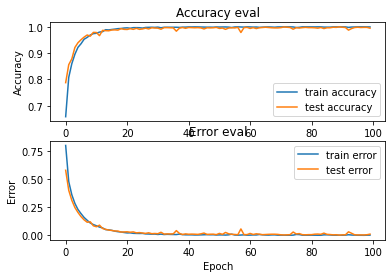

105/105 - 0s - loss: 0.0150 - accuracy: 0.9946 - 283ms/epoch - 3ms/step

Test accuracy: 0.9946091771125793


In [14]:
if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

In [15]:
SAVED_MODEL_PATH = "model.h5"
model.save(SAVED_MODEL_PATH)


In [8]:
import pandas as pd

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import librosa
import tensorflow as tf
import numpy as np
import math
SAVED_MODEL_PATH = "model.h5"
SAMPLE_RATE = 22050
TRACK_DURATION = 2 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


class _Keyword_Spotting_Service:
    """Singleton class for keyword spotting inference with trained models.

    :param model: Trained model
    """

    model = None
    _mapping = [
        "Bis'mi",
        "Al-lahi",
        "Al-rahmaani",
        "Al-raheemi"
    ]
    _instance = None


    def predict(self, file_path):
        """

        :param file_path (str): Path to audio file to predict
        :return predicted_keyword (str): Keyword predicted by the model
        """

        # extract MFCC
        MFCCs = self.preprocess(file_path)

        # we need a 4-dim array to feed to the model for prediction: (# samples, # time steps, # coefficients, 1)
        MFCCs = MFCCs[np.newaxis, ..., np.newaxis]

        # get the predicted label
        predictions = self.model.predict(MFCCs) # a 2d array [[]]
        predicted_index = np.argmax(predictions)
        # index return the index which has highest score
        predicted_keyword = self._mapping[predicted_index]
        # print('prediction',predicted_index,predicted_keyword)
        return predicted_keyword


    def preprocess(self, file_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
        """Extract MFCCs from audio file.

        :param file_path (str): Path of audio file
        :param num_mfcc (int): # of coefficients to extract
        :param n_fft (int): Interval we consider to apply STFT. Measured in # of samples
        :param hop_length (int): Sliding window for STFT. Measured in # of samples

        :return MFCCs (ndarray): 2-dim array with MFCC data of shape (# time steps, # coefficients)
        """
        samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
        num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
        # load audio file
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

        mfcc_lst = []
        for d in range(num_segments):

            # calculate start and finish sample for current segment
            start = samples_per_segment * d
            finish = start + samples_per_segment

            # extract mfcc - for each segment of signal
            mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
            mfcc = mfcc.T

            # store only mfcc feature with expected number of vectors
            if len(mfcc) == num_mfcc_vectors_per_segment:
              mfcc_lst.append(mfcc.tolist())
        return mfcc_lst


def Keyword_Spotting_Service():
    """Factory function for Keyword_Spotting_Service class.

    :return _Keyword_Spotting_Service._instance (_Keyword_Spotting_Service):
    """

    # ensure an instance is created only the first time the factory function is called
    if _Keyword_Spotting_Service._instance is None:
        _Keyword_Spotting_Service._instance = _Keyword_Spotting_Service()
        _Keyword_Spotting_Service.model = tf.keras.models.load_model(SAVED_MODEL_PATH)
    return _Keyword_Spotting_Service._instance




if __name__ == "__main__":

    # create 2 instances of the keyword spotting service
    kss = Keyword_Spotting_Service()
    kss1 = Keyword_Spotting_Service()

    # check that different instances of the keyword spotting service point back to the same object (singleton)
    assert kss is kss1

    # make a prediction
    keyword = kss.predict("003.wav")
    print(keyword)

/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=0
  warnings.warn(


ValueError: ignored